In [1]:
import haversine as hs
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import xarray as xr
import torch
from torch_geometric.data import Data, Dataset
from Trainer import Trainer
from wind_utils import get_distance, draw_graph, distance_threshold_graph, plot_heatmap, dataset_generation
from GCN_Regression import GCN_RegressionModel

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
lat_list = [28.815329,28.647622,28.695381,28.4706914,28.7762,28.7256504,28.5512005,28.656756,28.7500499,28.498571,28.5710274,28.655935,28.5627763,28.6811736,28.628624,28.73282,28.58028,28.588333,28.5918245,28.611281,28.636429,28.684678,28.60909,28.570173,28.822836,28.56789,28.6573814,28.530785,28.623763,28.674045,28.639645,28.639645,28.563262,28.732528,28.6514781,28.5504249,28.710508,28.531346,28.672342,28.699793]

In [3]:
df = data.to_dataframe().reset_index()
df = df.dropna(subset=["PM2.5", "WS", "WD"])
df['WD'] = 270-df['WD']
df = df[df["time"]=="2022-03-01 01:30:00"]

In [4]:
df

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,RH,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude
10200,"Anand Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,52.50,144.00,11.88,30.62,26.02,15.82,...,68.95,0.30,23.75,8.95,973.65,15.45,NaN,0.0,28.647622,77.315809
18983,"Ashok Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,79.00,134.00,7.47,67.17,41.80,50.77,...,71.30,0.38,63.10,5.43,987.17,13.82,0.0,0.0,28.695381,77.181665
36549,"Bawana, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,135.00,245.00,4.80,20.65,25.43,41.45,...,81.62,0.62,247.67,5.70,993.12,12.30,0.0,0.0,28.776200,77.051074
62898,"Chandni Chowk, Delhi - IITM",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,40.15,247.45,28.02,128.16,89.75,81.71,...,63.23,1.21,191.50,NaN,999.28,17.39,0.0,0.0,28.656756,77.227234
71681,"DTU, Delhi - CPCB",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,79.83,145.75,7.80,24.82,19.45,23.85,...,77.85,0.45,139.09,NaN,NaN,NaN,NaN,0.0,28.750050,77.111261
80464,"Dr. Karni Singh Shooting Range, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,78.50,218.75,73.85,95.58,111.05,14.77,...,72.95,0.88,-24.10,5.20,988.48,11.15,0.0,0.0,28.498571,77.264840
89247,"Dwarka-Sector 8, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,80.00,167.25,5.67,23.80,29.55,46.60,...,64.12,0.53,-78.10,5.70,990.60,14.65,0.0,0.0,28.571027,77.071901
115596,"IHBAS, Dilshad Garden, Delhi - CPCB",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,75.65,161.88,4.22,71.22,40.67,46.52,...,61.21,2.86,-73.42,12.80,NaN,16.47,NaN,0.0,28.681174,77.302523
133162,"Jahangirpuri, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,90.75,187.50,21.33,57.70,48.12,102.10,...,69.65,0.35,-74.20,2.62,992.97,14.07,0.0,0.0,28.732820,77.170633
141945,"Jawaharlal Nehru Stadium, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,72.75,157.50,62.20,82.93,94.78,25.00,...,87.00,1.47,136.90,3.45,994.73,12.90,0.0,0.0,28.580280,77.233829


In [5]:
G = distance_threshold_graph(df, 40)

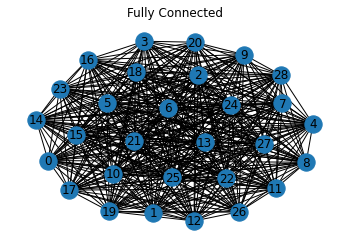

In [6]:
draw_graph(G, "Fully Connected")

In [7]:
node_features, edge_index, y = dataset_generation(G)

In [8]:
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

for i, node in enumerate(G.nodes):
    lat = G.nodes[node]['latitude']
    if lat in lat_list[:25]:
        train_mask[i] = True
    else:
        test_mask[i] = True


data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask = test_mask)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN_RegressionModel(4)

In [10]:
trainer = Trainer(model = model, data = data, device = device, epochs=2500)
trainer.train(lr=0.001)

Epoch 0: Train RMSE 101.1634, Test RMSE 91.8499
Epoch 100: Train RMSE 30.5627, Test RMSE 40.5936
Epoch 200: Train RMSE 29.6527, Test RMSE 39.6868
Epoch 300: Train RMSE 28.7573, Test RMSE 41.5269
Epoch 400: Train RMSE 28.0289, Test RMSE 43.3856
Epoch 500: Train RMSE 27.6094, Test RMSE 45.0593
Epoch 600: Train RMSE 27.4389, Test RMSE 46.3093
Epoch 700: Train RMSE 27.3616, Test RMSE 47.0973
Epoch 800: Train RMSE 27.2873, Test RMSE 47.4896
Epoch 900: Train RMSE 27.2326, Test RMSE 47.8777
Epoch 1000: Train RMSE 27.1637, Test RMSE 48.3076
Epoch 1100: Train RMSE 27.0699, Test RMSE 48.9385
Epoch 1200: Train RMSE 26.9273, Test RMSE 49.6933
Epoch 1300: Train RMSE 26.7195, Test RMSE 50.7770
Epoch 1400: Train RMSE 26.4260, Test RMSE 52.8991
Epoch 1500: Train RMSE 26.0489, Test RMSE 55.1705
Epoch 1600: Train RMSE 25.7151, Test RMSE 57.6816
Epoch 1700: Train RMSE 25.4827, Test RMSE 61.1605
Epoch 1800: Train RMSE 25.3788, Test RMSE 63.4892
Epoch 1900: Train RMSE 25.3243, Test RMSE 65.1061
Epoch 2000:

In [11]:
out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))

In [12]:
test_rmse.detach()

tensor(70.5087)

In [13]:
latitudes = np.array(df['latitude'])
longitudes = np.array(df['longitude'])
g_lat = np.linspace(latitudes.min()-0.1, latitudes.max()+0.1, 30)
g_long = np.linspace(longitudes.min()-0.1, longitudes.max()+0.1, 30)
lat_grid, lon_grid = np.meshgrid(g_lat, g_long)

# df['wind_direction'] = 270-df['WD']
df['wind_direction'] = df['WD']
u = df["WS"] * np.cos(np.radians(df["wind_direction"]))
v = df["WS"] * np.sin(np.radians(df["wind_direction"]))
u_ = u.mean()
v_ = v.mean()
ws = (np.sqrt(u_**2 + v_**2))
wd = (math.degrees(math.atan(v_/u_)))
test_ws = [ws]*len(lon_grid.flatten())
test_wd = [wd]*len(lon_grid.flatten())

train = df[['latitude', 'longitude', 'PM2.5', 'WS', 'WD']]
test = pd.DataFrame({'longitude':lon_grid.flatten(),
                     'latitude':lat_grid.flatten(),
                     'WS':test_ws, 
                     'WD':test_wd})

In [14]:
Gh = nx.Graph()

# Iterate over each row in the dataframe
for i in range(len(test)):
    lat1, lon1 = test.iloc[i]["latitude"], test.iloc[i]["longitude"]
    ws = test.iloc[i]['WS']
    wd = test.iloc[i]['WD']

    # Add a node to the graph with latitude, longitude, PM2.5, and station attributes
    Gh.add_node(i, latitude=lat1, longitude=lon1, ws = ws, wd = wd)

    # Iterate over the remaining rows to check for edges
    for j in range(i + 1, len(test)):
        lat2, lon2 = test.iloc[j]["latitude"], test.iloc[j]["longitude"]

        # Calculate the distance between the two nodes
        distance = get_distance(lat1, lon1, lat2, lon2)

        # Check if the distance is within the threshold
        if distance <= 12:
            # Add an edge between the nodes
            Gh.add_edge(i, j)

In [15]:
node_features = [(Gh.nodes[node]['latitude'], Gh.nodes[node]['longitude'], Gh.nodes[node]['ws'], Gh.nodes[node]['wd']) for node in Gh.nodes]
edge_index = torch.tensor(list(Gh.edges)).t().contiguous()

data_h = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index)

In [16]:
out = model(data_h.x.to(device), data_h.edge_index.to(device))
test['PM2.5'] = out.detach().numpy()

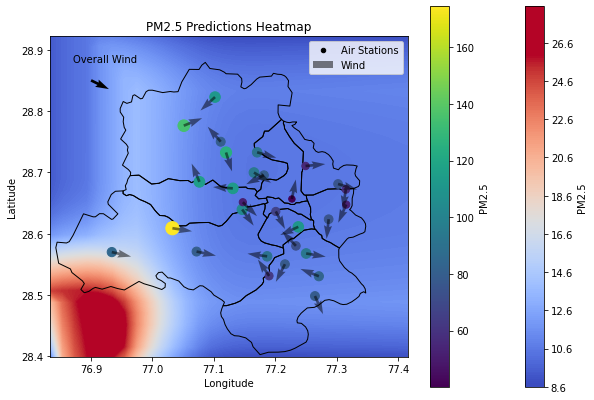

In [17]:
plot_heatmap(longitudes = np.array(test['longitude']), latitudes = np.array(test['latitude']), values = test['PM2.5'].values, df = df)

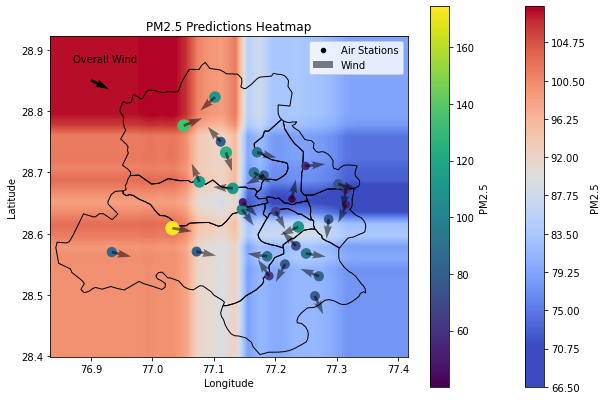

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
X_train = df[['latitude', 'longitude', 'WS', 'WD']]
y_train = df['PM2.5']
X_test = test[['latitude', 'longitude', 'WS', 'WD']]
rf.fit(X_train, y_train)
test['RF_PM2.5'] = rf.predict(X_test)
plot_heatmap(longitudes = np.array(test['longitude']), latitudes = np.array(test['latitude']), values = test['RF_PM2.5'].values, df = df)

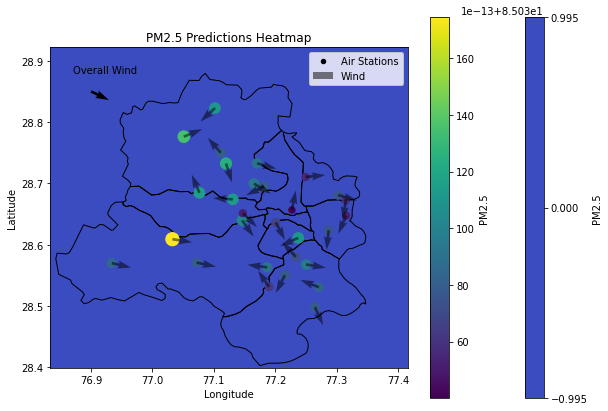

In [19]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
X_train = df[['latitude', 'longitude', 'WS', 'WD']]
y_train = df['PM2.5']
X_test = test[['latitude', 'longitude', 'WS', 'WD']]
knn.fit(X_train, y_train)
test['KNN_PM2.5'] = knn.predict(X_test)
plot_heatmap(longitudes = np.array(test['longitude']), latitudes = np.array(test['latitude']), values = test['KNN_PM2.5'].values, df = df)